In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial.distance import cdist
from skimage import measure
from matplotlib import pyplot as plt
import os
import tifffile
from tqdm import tqdm
from typing import List, Set, Tuple

In [2]:
data_raw = pd.read_csv(os.path.join("../../data/magnifications_matching",
                         f"20x_raw.field_thr.all.tsv"), sep="\t")

In [3]:
data_raw

,sid,nid,size,dilated_size,scaling,magnification,image_type,Channel,Nuclei,x,y,z,Value,FWHM,SNR,NSNR,Label,SNR2,Value2
0,1,94,3970,7457,1.0,20x,raw,a647,0,404.044,15.908,56.020,0.931,3.925,13.147,-1.000,0,6.448689,0.931
1,1,94,3970,7457,1.0,20x,raw,a647,0,404.125,17.037,52.854,0.839,3.766,14.446,-1.000,0,6.438891,0.839
2,1,94,3970,7457,1.0,20x,raw,a647,0,404.000,17.027,59.180,0.823,4.148,14.284,-1.000,0,9.761700,0.823
3,1,111,5754,12212,1.0,20x,raw,a647,0,413.027,579.941,53.188,0.808,2.856,14.646,-1.000,0,15.489744,0.808
4,1,84,7434,14410,1.0,20x,raw,a647,11,320.987,49.980,55.004,0.613,1.729,14.993,1.658,0,10.577747,0.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15372,7,130,7953,13126,1.0,20x,raw,a647,0,403.019,168.955,48.011,0.096,3.811,4.735,-1.000,0,4.343068,0.096
15373,7,154,4829,9065,1.0,20x,raw,a647,0,496.019,181.910,57.009,0.096,2.910,3.152,-1.000,0,2.892631,0.096
15374,7,91,8994,16058,1.0,20x,raw,a647,0,276.043,119.066,53.006,0.096,3.566,4.377,-1.000,0,3.565668,0.096
15375,7,146,5982,9533,1.0,20x,raw,a647,133,466.980,338.996,50.020,0.096,1.386,4.998,1.028,0,4.541584,0.096


In [4]:
current_field_id = 1

field_data = data_raw.loc[current_field_id == data_raw["sid"], ]
coords = data_raw.loc[current_field_id == data_raw["sid"], ("x", "y")]

In [5]:
d = cdist(coords, coords)

In [6]:
(d.min(), d.max())

(0.0, 844.5701021874976)

In [7]:
ddf = pd.DataFrame(np.array(np.where(d <= .5)).transpose(), columns=("A", "B"))

In [8]:
ddf2 = ddf.loc[ddf["A"] != ddf["B"], :]

In [9]:
ddf2

,A,B
2,1,2
3,2,1
9,6,7
10,7,6
13,8,810
...,...,...
3715,2198,851
3717,2199,1244
3720,2201,537
3721,2201,560


In [10]:
field_data.iloc[1:3, :]

,sid,nid,size,dilated_size,scaling,magnification,image_type,Channel,Nuclei,x,y,z,Value,FWHM,SNR,NSNR,Label,SNR2,Value2
1,1,94,3970,7457,1.0,20x,raw,a647,0,404.125,17.037,52.854,0.839,3.766,14.446,-1.0,0,6.438891,0.839
2,1,94,3970,7457,1.0,20x,raw,a647,0,404.000,17.027,59.180,0.823,4.148,14.284,-1.0,0,9.761700,0.823


In [11]:
grouped: List[Set[int]] = []
added: Set[int] = set()
for dot_id in set(ddf["A"].values):
    if not dot_id in added:
        selected = ddf.loc[ddf["A"] == dot_id, "B"].values
        for selected_id in selected:
            assert selected_id not in added
            added.add(selected_id)
        grouped.append(set(selected))

In [12]:
cleaned_df_list: List[pd.DataFrame] = [field_data.iloc[[i for i in range(field_data.shape[0]) if i not in added], :]]
for group in grouped:
    ids = list(group)
    if 1 == len(group):
        selected_id = ids[0]
    else:
        selected_id = ids[np.argmax(data_raw.loc[ids, "SNR2"])]
        #print(f"Discarding {len(ids)-1} dots.")
    cleaned_df_list.append(field_data.iloc[[selected_id], :])
cleaned_df = pd.concat(cleaned_df_list)

In [13]:
print(cleaned_df.shape)
print(field_data.shape)

(1554, 19)
(2203, 19)


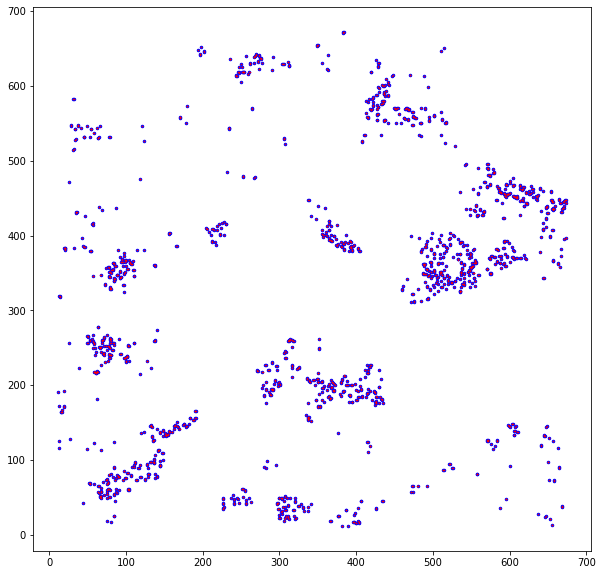

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(cleaned_df["x"], cleaned_df["y"], "b.", markersize=5)
plt.plot(field_data["x"], field_data["y"], "r.", markersize=1)

(array([2.807e+03, 5.600e+02, 2.480e+02, 8.800e+01, 1.800e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 1.200e+01, 3.200e+01,
        7.800e+01, 2.080e+02, 3.780e+02, 5.260e+02, 4.140e+02, 2.460e+02,
        1.000e+02, 4.200e+01, 3.400e+01, 6.800e+01, 1.400e+02, 2.740e+02,
        2.880e+02, 2.060e+02, 9.800e+01, 4.400e+01, 1.200e+01, 4.000e+00,
        2.000e+00, 4.000e+00, 6.000e+00, 4.000e+01, 3.600e+01, 5.800e+01,
        1.000e+02, 7.600e+01, 9.400e+01, 1.160e+02, 1.640e+02, 1.100e+02,
        8.600e+01, 7.600e+01, 3.600e+01, 1.000e+01, 4.000e+00, 4.000e+00,
        4.000e+00, 2.000e+01, 3.200e+01, 6.800e+01, 6.800e+01, 7.200e+01,
        8.200e+01, 6.800e+01, 7.600e+01, 1.100e+02, 1.180e+02, 1.380e+02,
        1.140e+02, 7.600e+01, 3.400e+01, 4.200e+01, 4.600e+01, 4.200e+01,
        6.800e+01, 8.800e+01, 1.300e+02, 1.160e+02, 7.200e+01, 2.400e+01,
        2.800e+01, 4.200e+01, 4.400e+0

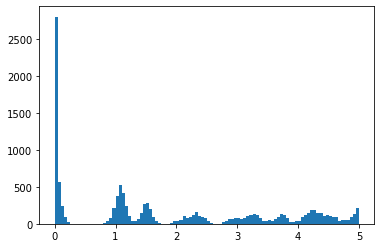

In [15]:
plt.hist(d.flatten()[d.flatten() <= 5], bins=100)